# Install Dependencies

In [ ]:
%pip install numpy pandas xgboost tensorflow scikit-learn matplotlib "dask[dataframe]"


# Unzip Data

In [ ]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

# Load and Preprocess Data
*   Load Data
*   Sort data chronologically and generate lag-based features
*   Handle missing data and outliers


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load datasets
epidemiology = pd.read_csv("epidemiology.csv")
geography = pd.read_csv("geography.csv")

# Convert date to datetime format
epidemiology["date"] = pd.to_datetime(epidemiology["date"])

# Merge datasets on 'key' and 'date'
merged_df = epidemiology.merge(geography, on="location_key", how="left")

# Filter out columns needed
merged_df = merged_df[['date', 'location_key', 'new_confirmed', 'new_deceased',
       'cumulative_confirmed', 'cumulative_deceased', 'latitude', 'longitude']]

# Handle missing data and negative new_confirmed cases
merged_df.dropna(subset=["new_confirmed", "latitude", "longitude", "cumulative_confirmed", "new_deceased", "cumulative_deceased"], inplace=True)
merged_df = merged_df[merged_df["new_confirmed"] >= 0]

# Sort by date is essential for time series analysis
merged_df.sort_values(by="date", inplace=True, ascending=True)

# Create lag features from previous day and week
merged_df["new_confirmed_lag_1"] = merged_df.groupby("location_key")["new_confirmed"].shift(1)
merged_df["new_confirmed_lag_7"] = merged_df.groupby("location_key")["new_confirmed"].shift(7)
merged_df.dropna(subset=["new_confirmed_lag_1", "new_confirmed_lag_7"], inplace=True)

# 2022 Weekly New Cases

In [ ]:
year_to_plot = 2022  # Change this to the desired year
df = merged_df[merged_df["date"].dt.year == year_to_plot]
df = merged_df[merged_df['location_key'].str[:2] == 'US']

df["week"] = df["date"].dt.to_period("W")  # Create week-based grouping

df_weekly = df.groupby(["week"]).agg({
    "latitude": "first", "longitude": "first", "new_confirmed": "sum"
}).reset_index()
df_weekly["week"] = df_weekly["week"].astype(str)
df_weekly["week"] = df_weekly["week"].apply(lambda x: str(x).split("/")[0])  # Extract start date
df_weekly["week"] = pd.to_datetime(df_weekly["week"]).dt.strftime("%Y-%m-%dT00:00:00Z")



import folium
from folium.plugins import TimestampedGeoJson

# Base map centered on first recorded outbreak
m = folium.Map(location=[df_weekly.iloc[0]["latitude"], df_weekly.iloc[0]["longitude"]], zoom_start=1)

# Convert data into GeoJSON format for time-series animation
features = []
for _, row in df_weekly.iterrows():
    feature = {
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [row["longitude"], row["latitude"]]},
        "properties": {
            "time": row["week"],
            "popup": f"Week: {row['week']}\nCases: {row['new_confirmed']}",
            "icon": "circle",
            "iconstyle": {"color": "red", "radius": 8}
        }
    }
    features.append(feature)

# Add animated outbreak markers
TimestampedGeoJson({"type": "FeatureCollection", "features": features}, period="P7D", add_last_point=True).add_to(m)

m.save("monthly_cases_map.html")

# Display map in Jupyter Notebook
m


<ipython-input-4-0bc58cd38ef5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week"] = df["date"].dt.to_period("W")  # Create week-based grouping


# Split Test and Training Data
*   Scale and Encode Features




In [ ]:
# Scale and Encode features
scaler = MinMaxScaler()
encoder = LabelEncoder()

merged_df["location_key"] = encoder.fit_transform(merged_df["location_key"])

X_scaled = scaler.fit_transform(merged_df.drop(columns=["date", "new_confirmed"]))
y = merged_df["new_confirmed"]

# Splitting data for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#Train XGBoost for Case Predictions
*   Structured learning using gradient boosting



In [ ]:
# Train XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)
feature_names = list(merged_df.drop(columns=["date", "new_confirmed"]).columns)
xgb_model.fit(X_train, y_train)
xgb_model.get_booster().feature_names = feature_names
xgb_preds = xgb_model.predict(X_test)
print(f"Model R² Score: {xgb_model.score(X_test, y_test)}")


Model R² Score: 0.9055744575370175


#Top-ranking features used by XGBoost

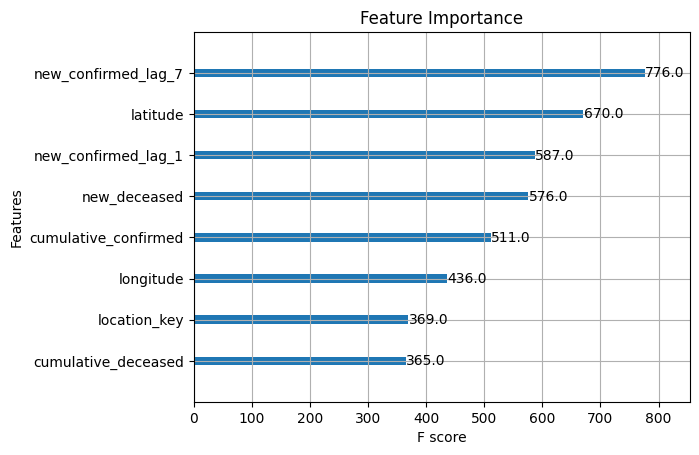

In [ ]:
xgb.plot_importance(xgb_model, importance_type="weight", title="Feature Importance")
plt.show()

#Train GRU for Sequential Learning


In [ ]:
# Train GRU Model

# XLA Compilation for faster training
tf.config.optimizer.set_jit(True)
set_global_policy("mixed_float16")

# Reshape for GRU input format: (samples, timesteps, features)
X_train_gru = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train_gru.shape[1], 1),
        activation="tanh",
        recurrent_activation='sigmoid',
        dropout=0,
        recurrent_dropout=0,
        unroll=False,
        use_bias=True,
        reset_after=True,
        ),
    Dropout(0.2),
    GRU(50, activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0,
        recurrent_dropout=0,
        unroll=False,
        use_bias=True,
        reset_after=True,
        ),
    Dropout(0.2),
    Dense(1)
])

# Cast for better computations
X_train_gru = X_train_gru.astype("float32")
X_test_gru = X_test_gru.astype("float32")

optimizer = Adam(learning_rate=0.1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.0001)

# Compile and train model
gru_model.compile(loss="mean_squared_error", optimizer=optimizer)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_gru, y_train)).batch(2048).prefetch(tf.data.AUTOTUNE)

gru_model.fit(train_dataset, epochs=1, validation_data=(X_test_gru, y_test), callbacks=[lr_scheduler])
gru_preds = gru_model.predict(X_test_gru).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4334/4334 ━━━━━━━━━━━━━━━━━━━━ 194s 44ms/step - loss: 92063112.0000 - val_loss: 83347096.0000 - learning_rate: 0.1000
69332/69332 ━━━━━━━━━━━━━━━━━━━━ 101s 1ms/step


# Hybrid Ensemble Prediction
*   Blend structured and sequential models



In [ ]:

ensemble_preds = 0.9 * xgb_preds + 0.1 * gru_preds

mae_xgb = mean_absolute_error(y_test, xgb_preds)
mae_gru = mean_absolute_error(y_test, gru_preds)
mae_ensemble = mean_absolute_error(y_test, ensemble_preds)

print(f"XGBoost MAE with Location-Based Lag Features: {mae_xgb:.4f}")
print(f"GRU MAE: {mae_gru:.4f}")
print(f"Hybrid Ensemble MAE: {mae_ensemble:.4f}")
print(y_test.head())
print(gru_preds[:5])
print(xgb_preds[:5])
print(ensemble_preds[:5])


XGBoost MAE with Location-Based Lag Features: 80.5354
GRU MAE: 246.5277
Hybrid Ensemble MAE: 87.6898
12041668     9.0
3821723      2.0
12209301    34.0
11888310    54.0
1075248      6.0
Name: new_confirmed, dtype: float64
[130.5 130.5 130.5 130.5 130.5]
[ 8.13624    2.17234   36.87974   69.69784    4.6680474]
[20.369492 15.001981 46.23864  75.77493  17.248117]


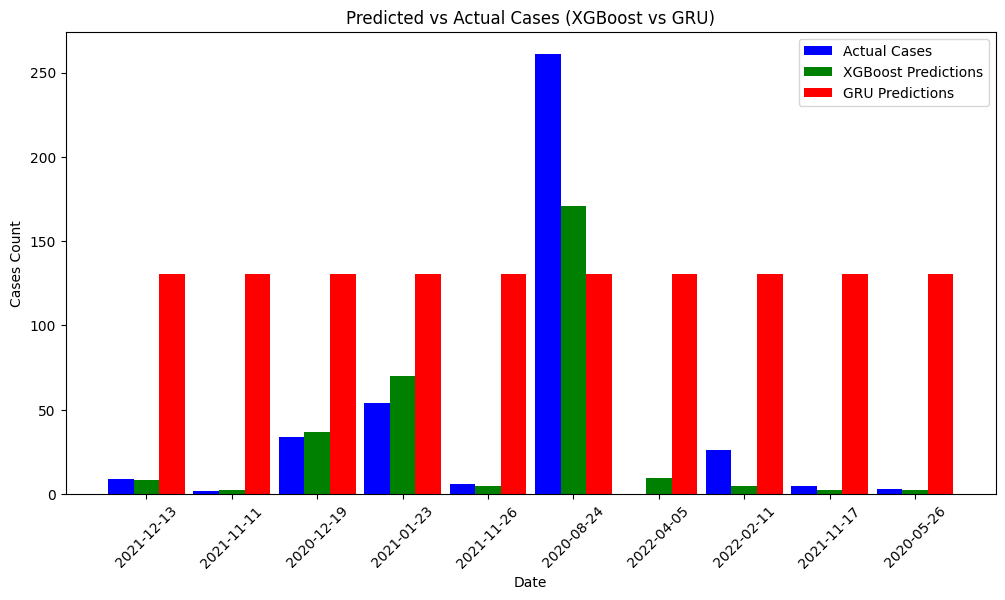

In [ ]:
df_actual = y_test.to_frame().merge(merged_df[["date"]], left_index=True, right_index=True)[:10]

df_results = pd.DataFrame({
    "date": df_actual["date"],
    "actual_cases": df_actual["new_confirmed"],
    "xgboost_pred": xgb_preds[:10],
    "gru_pred": gru_preds[:10]
})

# Define bar width & positions
x_labels = df_results["date"].dt.strftime("%Y-%m-%d")  # Convert dates for readability
x = np.arange(len(x_labels))  # Numeric positions for bars
width = 0.3  # Space between bars

plt.figure(figsize=(12, 6))
plt.bar(x, df_results["actual_cases"], width, label="Actual Cases", color="blue")
plt.bar(x + width, df_results["xgboost_pred"], width, label="XGBoost Predictions", color="green")
plt.bar(x + width * 2, df_results["gru_pred"], width, label="GRU Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Cases Count")
plt.title("Predicted vs Actual Cases (XGBoost vs GRU)")
plt.xticks(x + width, x_labels, rotation=45)
plt.legend()
plt.show()